# Predictive Maintenance using CatBoost

## 1. Introduction

This project focuses on predicting machine failures using the **AI4I 2020 Predictive Maintenance Dataset** from the UCI Machine Learning Repository.
The goal is to build a robust classification model that can accurately identify potential failures, enabling proactive maintenance.

We will use **CatBoost**, a gradient boosting library that handles categorical features automatically and is robust to overfitting. Given the class imbalance (failures are rare), we will leverage CatBoost's built-in handling for imbalanced data.

In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve

# Set visual style
sns.set(style='whitegrid', palette='muted')
%matplotlib inline

print("Libraries loaded.")

Libraries loaded.


## 2. Data Loading & Inspection

In [3]:
# Load dataset
try:
    df = pd.read_csv('ai4i2020.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("File not found. Please ensure 'ai4i2020.csv' is in the working directory.")

# Display first few rows
df.head()

Dataset loaded successfully.


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
# Check for duplicates and missing values
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Missing values:\n{df.isnull().sum()}")

Duplicates: 0
Missing values:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


## 3. Exploratory Data Analysis (EDA)

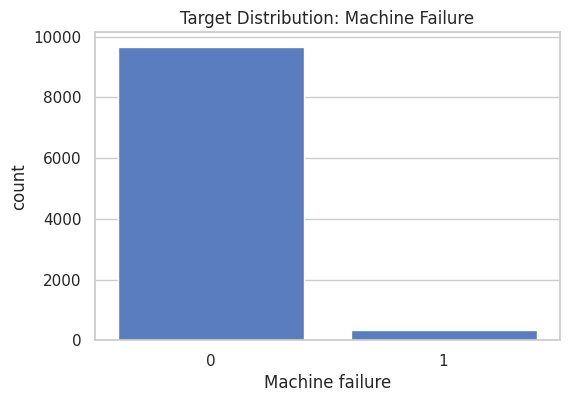

Failure Ratio:
Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64


In [6]:
# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Machine failure', data=df)
plt.title('Target Distribution: Machine Failure')
plt.show()

failure_ratio = df['Machine failure'].value_counts(normalize=True)
print(f"Failure Ratio:\n{failure_ratio}")

**Observation**: The dataset is highly imbalanced, with 'No Failure' being the majority class.

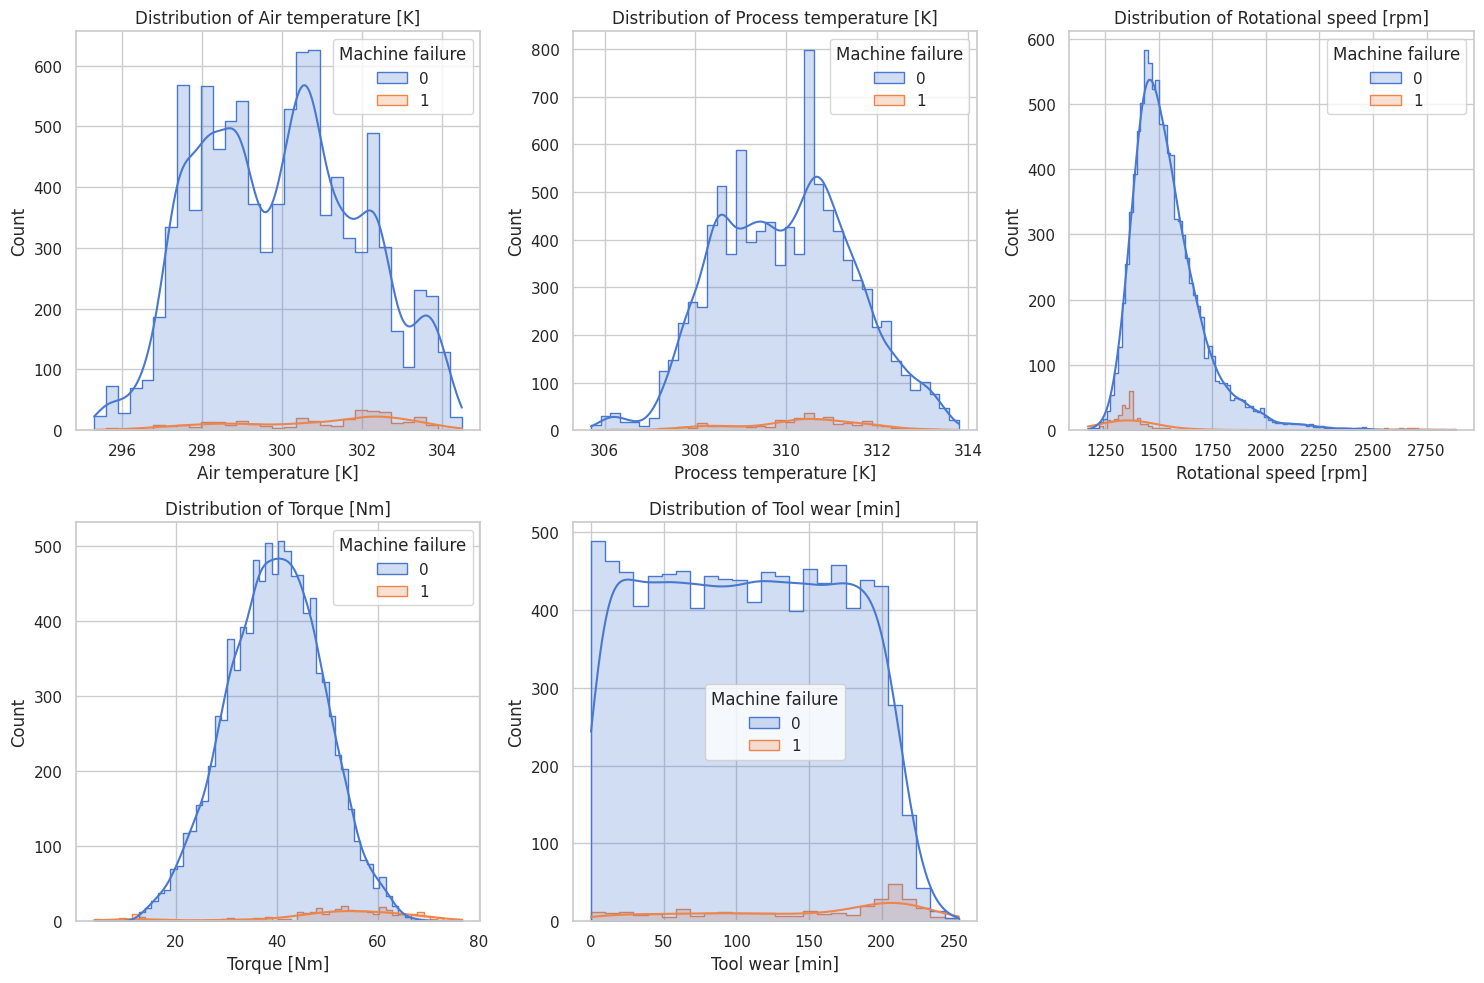

In [7]:
# Numerical Features Distribution
num_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=col, hue='Machine failure', kde=True, element="step", common_norm=False)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

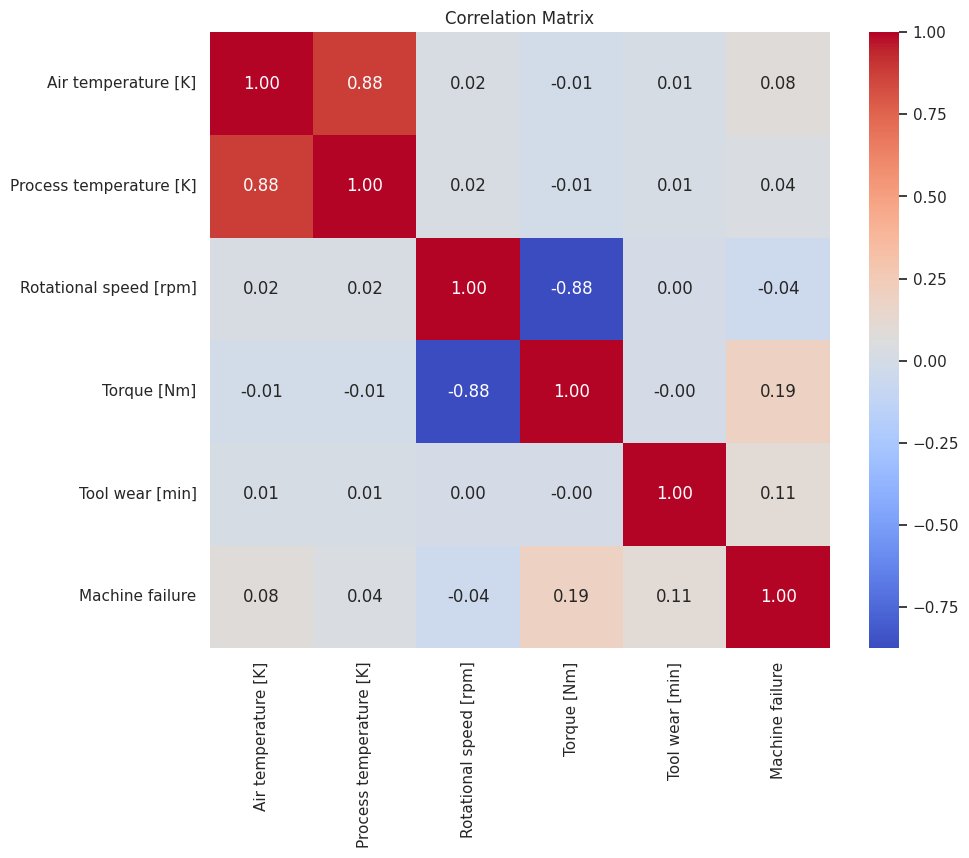

In [8]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
corr = df[num_features + ['Machine failure']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 4. Data Preprocessing
We will drop irrelevant columns (`UDI`, `Product ID`) and prepare the data for the model.
CatBoost can handle categorical variables (`Type`) directly, so usually we don't need manual One-Hot Encoding.

In [9]:
# Drop IDs
clean_df = df.drop(['UDI', 'Product ID'], axis=1)

# Ensure 'Type' is treated as a categorical feature (string/object is fine for CatBoost, no need to map if passed correctly)
# Checking unique values
print("Unique Types:", clean_df['Type'].unique())

# Define Features (X) and Target (y)
X = clean_df.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
# Note: TWF, HDF, etc. are specific failure types (targets) or derived from failure.
# If the goal is to predict 'Machine failure' based on sensors, we should probably drop specific failure flags as they are outcomes, not features, or risk data leakage.
# However, if predictive maintenance implies predicting *any* failure, we just use the sensors.

y = clean_df['Machine failure']

print("Features:", X.columns.tolist())
print("Target: Machine failure")

Unique Types: ['M' 'L' 'H']
Features: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Target: Machine failure


In [10]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (8000, 6)
Test shape: (2000, 6)


## 5. Model Training (CatBoost)
We use `CatBoostClassifier`. We specify `cat_features` for the column 'Type'.
To handle imbalance, we can use `auto_class_weights='Balanced'` or `scale_pos_weight`.

In [11]:
# Identify Categorical Features Indices
cat_features_indices = np.where(X.dtypes != float)[0]
print("Categorical Features Indices:", cat_features_indices)

# Initialize CatBoost
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    cat_features=cat_features_indices,
    auto_class_weights='Balanced',
    verbose=200,
    early_stopping_rounds=50,
    eval_metric='AUC'
)

# Train
model.fit(X_train, y_train, eval_set=(X_test, y_test))

Categorical Features Indices: [0 3 5]
0:	test: 0.8437310	best: 0.8437310 (0)	total: 65.8ms	remaining: 1m 5s
200:	test: 0.9436122	best: 0.9436122 (198)	total: 5.49s	remaining: 21.8s
400:	test: 0.9478672	best: 0.9478672 (400)	total: 10.3s	remaining: 15.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9497701254
bestIteration = 532

Shrink model to first 533 iterations.


## 6. Evaluation

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1932
           1       0.35      0.81      0.49        68

    accuracy                           0.94      2000
   macro avg       0.67      0.88      0.73      2000
weighted avg       0.97      0.94      0.95      2000

Confusion Matrix:



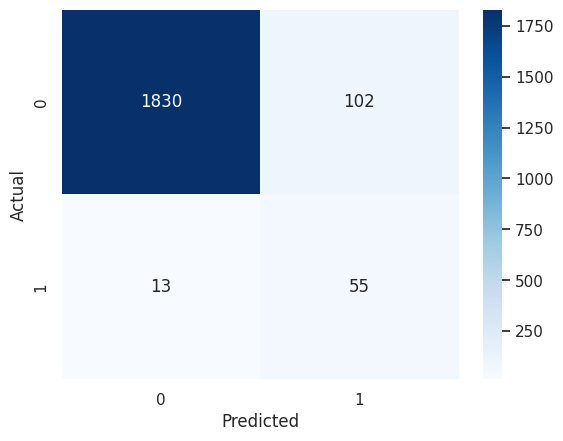

ROC-AUC Score: 0.9498


In [12]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

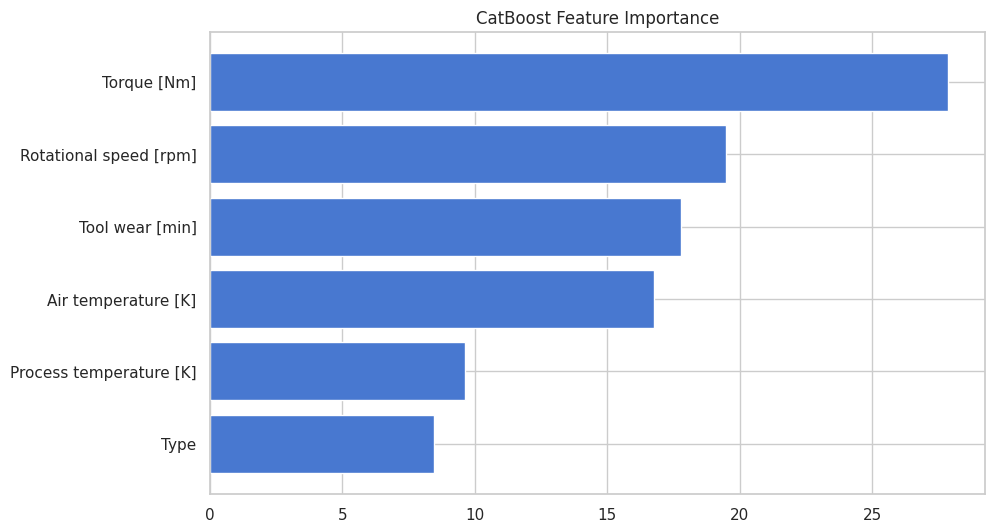

In [13]:
# Feature Importance
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('CatBoost Feature Importance')
plt.show()

## 7. Comparative Analysis & Optimization
To address the low precision while maintaining recall, we obtain the optimal probability threshold and tune hyperparameters.

In [14]:
# 7.1 Threshold Tuning
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Best F1-Score: {f1_scores[optimal_idx]:.4f}")

y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
print("\nClassification Report (Optimal Threshold):\n")
print(classification_report(y_test, y_pred_optimal))

Optimal Threshold: 0.8011
Best F1-Score: 0.6423

Classification Report (Optimal Threshold):

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.64      0.65      0.64        68

    accuracy                           0.98      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.98      0.98      0.98      2000



In [15]:
# 7.2 Hyperparameter Tuning
params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [500, 1000]
}

tuned_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    cat_features=cat_features_indices,
    silent=True,
    eval_metric='F1'
)

grid_search_result = tuned_model.randomized_search(
    params,
    X=X_train,
    y=y_train,
    cv=3,
    plot=False,
    verbose=False
)

print("Best Parameters:", grid_search_result['params'])


bestTest = 0.9333808348
bestIteration = 486


bestTest = 0.9312474559
bestIteration = 374


bestTest = 0.9085459046
bestIteration = 480


bestTest = 0.925471539
bestIteration = 95


bestTest = 0.9291634935
bestIteration = 326


bestTest = 0.9382940273
bestIteration = 76


bestTest = 0.9152273943
bestIteration = 299


bestTest = 0.9140052783
bestIteration = 22


bestTest = 0.9158396787
bestIteration = 359


bestTest = 0.916759643
bestIteration = 111

Training on fold [0/3]

bestTest = 0.894505049
bestIteration = 24

Training on fold [1/3]

bestTest = 0.8725081678
bestIteration = 30

Training on fold [2/3]

bestTest = 0.9045539348
bestIteration = 70

Best Parameters: {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 1000}


In [16]:
# 7.3 Final Comparison
best_model = CatBoostClassifier(
    **grid_search_result['params'],
    auto_class_weights='Balanced',
    cat_features=cat_features_indices,
    verbose=0
)
best_model.fit(X_train, y_train)

y_pred_tuned = best_model.predict(X_test)
print("\nBaseline Model Report:")
print(classification_report(y_test, y_pred))
print("\nTuned Model Report:")
print(classification_report(y_test, y_pred_tuned))


Baseline Model Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1932
           1       0.35      0.81      0.49        68

    accuracy                           0.94      2000
   macro avg       0.67      0.88      0.73      2000
weighted avg       0.97      0.94      0.95      2000


Tuned Model Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.61      0.63      0.62        68

    accuracy                           0.97      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.97      0.97      0.97      2000



## 8. Advanced Optimization: Feature Engineering
Inspired by top-performing kernels, we create features based on physical properties:
- **Power**: $P \approx \tau \times \omega$ (Torque $\times$ Rotational Speed)
- **Temperature Difference**: $T_{process} - T_{air}$
- **Wear Stress**: Tool Wear $\times$ Torque (Interaction of history and load)

In [17]:
# 8.1 Create New Features
df_eng = clean_df.copy()

df_eng['Power'] = df_eng['Torque [Nm]'] * df_eng['Rotational speed [rpm]']
df_eng['Temp_Diff'] = df_eng['Process temperature [K]'] - df_eng['Air temperature [K]']
df_eng['Wear_Stress'] = df_eng['Tool wear [min]'] * df_eng['Torque [Nm]']

# Redefine X and y
X_eng = df_eng.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y_eng = df_eng['Machine failure']

# Split
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng)

print("New Feature Set:", X_eng.columns.tolist())

New Feature Set: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Power', 'Temp_Diff', 'Wear_Stress']


In [18]:
# 8.2 Train Optimized Model on Engineered Data
cat_features_indices_eng = np.where(X_eng.dtypes != float)[0]

final_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    cat_features=cat_features_indices_eng,
    auto_class_weights='Balanced',
    verbose=200,
    early_stopping_rounds=50,
    eval_metric='F1'
)

final_model.fit(X_train_eng, y_train_eng, eval_set=(X_test_eng, y_test_eng))

0:	learn: 0.8057104	test: 0.7906339	best: 0.7906339 (0)	total: 12.6ms	remaining: 18.9s
200:	learn: 0.9543763	test: 0.9263624	best: 0.9263624 (199)	total: 3.19s	remaining: 20.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9285514293
bestIteration = 239

Shrink model to first 240 iterations.


Final Optimal Threshold: 0.8503

Final Model Report (with Feature Engineering & Threshold Tuning):

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.85      0.78      0.82        68

    accuracy                           0.99      2000
   macro avg       0.92      0.89      0.90      2000
weighted avg       0.99      0.99      0.99      2000



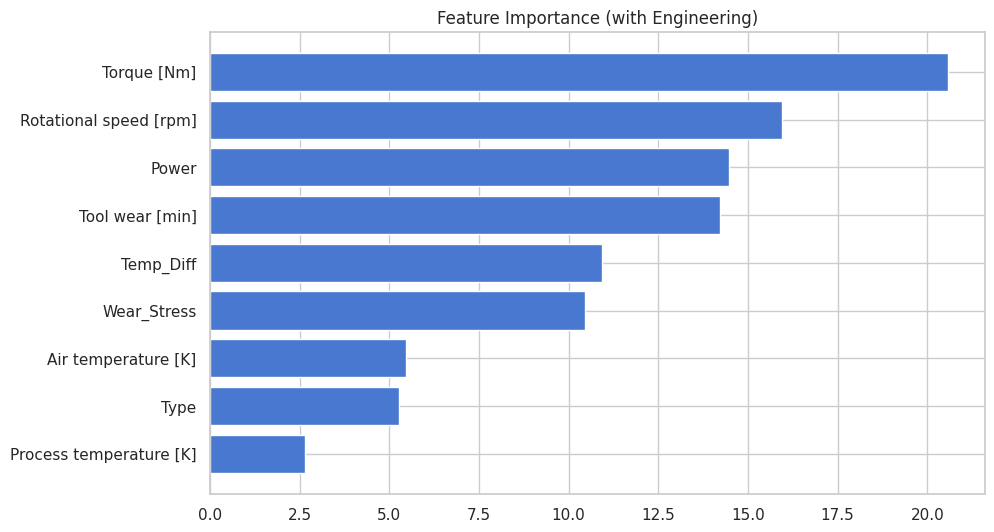

In [19]:
# 8.3 Final Evaluation
y_pred_final = final_model.predict(X_test_eng)
y_prob_final = final_model.predict_proba(X_test_eng)[:, 1]

# Optimize Threshold again for this new model
precisions, recalls, thresholds = precision_recall_curve(y_test_eng, y_prob_final)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_final = thresholds[optimal_idx]

y_pred_final_opt = (y_prob_final >= optimal_threshold_final).astype(int)

print(f"Final Optimal Threshold: {optimal_threshold_final:.4f}")
print("\nFinal Model Report (with Feature Engineering & Threshold Tuning):\n")
print(classification_report(y_test_eng, y_pred_final_opt))

# Feature Importance Comparison
feature_importance = final_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_eng.columns)[sorted_idx])
plt.title('Feature Importance (with Engineering)')
plt.show()

In [20]:
!pip install xgboost


In [21]:
pip install -U imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.14.0
    Uninstalling imbalanced-learn-0.14.0:
      Successfully uninstalled imbalanced-learn-0.14.0


In [22]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 9.1 SMOTE Data Augmentation
# Note: We need to One-Hot Encode 'Type' for SMOTE and XGBoost as they don't handle strings natively like CatBoost
X_eng_ohe = pd.get_dummies(X_eng, drop_first=True)

# Clean column names for XGBoost
X_eng_ohe.columns = [col.replace('[K]', '_K').replace('[Nm]', '_Nm').replace('[rpm]', '_rpm').replace('[min]', '_min').replace(' ', '_') for col in X_eng_ohe.columns]

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_eng_ohe, y_eng, test_size=0.2, random_state=42, stratify=y_eng)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_ohe, y_train_ohe)
print(f"Original Train Shape: {X_train_ohe.shape}")
print(f"Resampled Train Shape: {X_train_smote.shape}")

# 9.2 Train XGBoost on SMOTE data
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train_smote, y_train_smote)

# 9.3 Ensemble (Soft Voting)
p_cat = final_model.predict_proba(X_test_eng)[:, 1]

# XGBoost Predict
p_xgb = xgb_model.predict_proba(X_test_ohe)[:, 1]

# Average
p_ensemble = (p_cat + p_xgb) / 2

# Evaluate Ensemble
precisions, recalls, thresholds = precision_recall_curve(y_test_eng, p_ensemble)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_ens = thresholds[optimal_idx]

y_pred_ensemble = (p_ensemble >= optimal_threshold_ens).astype(int)

print(f"Ensemble Optimal Threshold: {optimal_threshold_ens:.4f}")
print("\nEnsemble Model Report:\n")
print(classification_report(y_test_eng, y_pred_ensemble))

Original Train Shape: (8000, 10)
Resampled Train Shape: (15458, 10)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Optimal Threshold: 0.8520

Ensemble Model Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.93      0.78      0.85        68

    accuracy                           0.99      2000
   macro avg       0.96      0.89      0.92      2000
weighted avg       0.99      0.99      0.99      2000

